In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cm
%matplotlib inline

# Nivell 1
#### Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-means.

El dataset es muy grande para ser procesado por el algoritmo de clustering jerárquico, da problemas de memoria, por lo que vamos a usar muestras aleatorias de nuestro dataset para trabajar con este algoritmo y Kmeans.

Hemos trabajado con tres modelos y les hemos aplicado Kmeans y clustering jerárquico:
- En el **primer modelo** hemos aplicado un clustering usando un gran número de variables, todas las **variables numéricas y tres categóricas**, para encontrar los patrones ocultos del dataset. Tiene un comportamiento distinto según el algoritmo usado.
En KMeans, la gráfica de inertia no permite localizar visualmente el número de clusters apropiado para segmentar, es una línea recta con pendiente descendiente lo que demuestra que las muestras se van agrupando  en clusteres de mismo tamaño. Además los valores de silhouette son muy bajos, el máximo es aún negativo (-0.03) para un número K=35 de clústers.
En el dendrograma el clustering más apropiado sería k=2 aunque no ofrece una información clara visualmente.
En el aglomerativo, al estudiar diferentes clusters, tenemos un resultado mucho mejor, obtenemos una silhouette máxima (0.4) para K=2.

- En el **segundo modelo** vamos a trabajar con **variables numéricas y con una variable categórica UniqueCarrier**. Aquí ya obtenemos una mejor segmentación que en el KMeans anterior, aunque eleveda K=22, es el valor con la menor inertia y la mayor silhouette (0.30), que coincide casi con el número de distintas categorías que tiene UniqueCarrier(20 aerolíneas). Hemos hecho una tabla cruzada entre las etiquetas obtenidas y UniqueCarrier y coinciden en su gran mayoría por lo que podemos deducir que el clustering está segmentado en gran parte por las distintas aerolíneas de UniqueCarrier.
En este caso tanto KMeans como aglomerativo tienen un comportamiento similar.

- En **tercer** lugar vamos a trabajar con **variables numéricas** solamente. Aquí el mejor valor de silhouette es para K=2 en los dos algoritmos aunque el Kmeans tiene una silhouette ligeramente superior que el aglomerativo, 0.23 vs 0.21 respectivamente.

In [3]:
#Leemos el dataset de las aerolíneas
df=pd.read_csv('Desktop/DataScience/datasets/DelayedFlights/DelayedFlights.csv')
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


**Preprocesado**

In [4]:
#Eliminamos el índice Unnamed, las fechas y la matrícula del avión
df_=df.drop(['Unnamed: 0','Year','Month','DayofMonth','TailNum'], 'columns')
#Eliminamos nulos
df_=df_.dropna()
#Cogemos 2000 muestras
df_s=df_.sample(2000)

In [5]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 365820 to 353181
Data columns (total 25 columns):
DayOfWeek            2000 non-null int64
DepTime              2000 non-null float64
CRSDepTime           2000 non-null int64
ArrTime              2000 non-null float64
CRSArrTime           2000 non-null int64
UniqueCarrier        2000 non-null object
FlightNum            2000 non-null int64
ActualElapsedTime    2000 non-null float64
CRSElapsedTime       2000 non-null float64
AirTime              2000 non-null float64
ArrDelay             2000 non-null float64
DepDelay             2000 non-null float64
Origin               2000 non-null object
Dest                 2000 non-null object
Distance             2000 non-null int64
TaxiIn               2000 non-null float64
TaxiOut              2000 non-null float64
Cancelled            2000 non-null int64
CancellationCode     2000 non-null object
Diverted             2000 non-null int64
CarrierDelay         2000 non-null float64
W

In [6]:
#Tenemos 4 variables categóricas
print('Valores distintos de UniqueCarrier:',len(df_s.UniqueCarrier.unique()))
print('Valores distintos de Origin:',len(df_s.Origin.unique()))
print('Valores distintos de Dest:',len(df_s.Dest.unique()))
print('Valores distintos de CancellationCode:',len(df_s.CancellationCode.unique()))

Valores distintos de UniqueCarrier: 19
Valores distintos de Origin: 180
Valores distintos de Dest: 199
Valores distintos de CancellationCode: 1


In [7]:
#Después de eliminar todas las muestras que contienen un null vemos que  CancellationCode solo tiene un valor
#por lo que podemos eliminarla ya que no aporta valor
df_s.drop('CancellationCode','columns', inplace=True)

**Primer Modelo:**

Features numéricas y 3 categóricas

In [8]:
#Variables dummies
X_dummies=pd.get_dummies(data=df_s, columns=['UniqueCarrier','Origin','Dest'],drop_first=True)

In [9]:
#Estandarización
from sklearn.preprocessing import StandardScaler
df_ts = StandardScaler().fit_transform(X_dummies)
df1=pd.DataFrame(df_ts,columns=X_dummies.columns, index=X_dummies.index)

**Kmeans modelo 1**

In [10]:
#40 clusters
ks=range(2,41)
inertias=[]
sil_K=[]
for i in ks:
    model=KMeans(n_clusters=i, random_state=0)
    model.fit(df1)   
    inertias.append(model.inertia_)    
    labels = model.predict(df1)
    silhouette_avg = silhouette_score(df1,labels)
    sil_K.append(silhouette_avg)

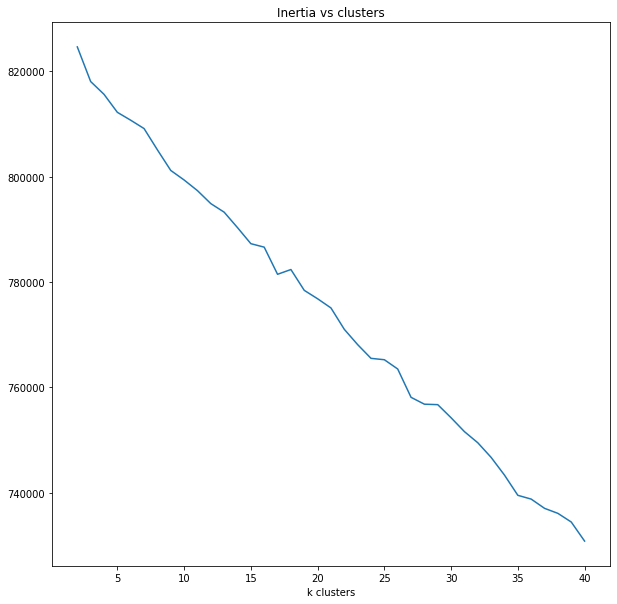

In [11]:
#Inertia
plt.figure(figsize=(10,10))
plt.plot(ks,inertias)
plt.xlabel('k clusters')
plt.title('Inertia vs clusters')
plt.show()

**Dendrograma modelo1**

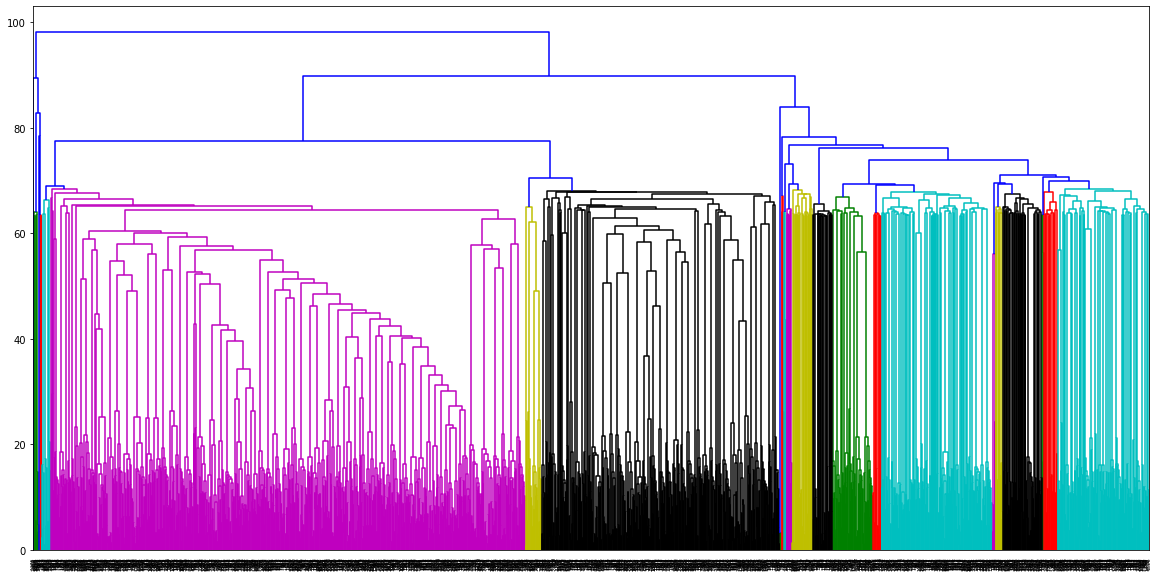

In [12]:
plt.figure(figsize=(20,10))
X=df1.values
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

**Agglomerative Clustering modelo1**

In [13]:
sil_Ac=[]
for i in ks:    
    model=AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X,labels)
    sil_Ac.append(silhouette_avg)

**Silhouette modelo1**

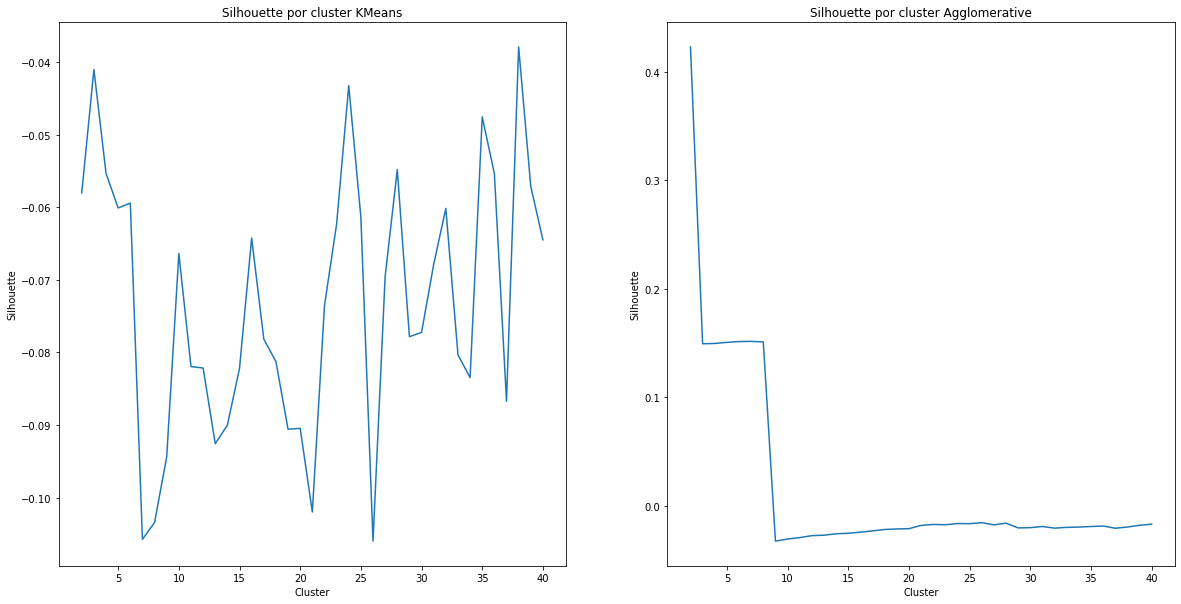

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(ks,sil_K)
plt.title('Silhouette por cluster KMeans')
plt.xlabel('Cluster')
plt.ylabel('Silhouette')

plt.subplot(1,2,2)
plt.plot(ks,sil_Ac)
plt.title('Silhouette por cluster Agglomerative')
plt.xlabel('Cluster')
plt.ylabel('Silhouette')
plt.show()

In [15]:
#Silhouette maximo,n clusters
print('Kmeans:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_K),ks[np.argmax(sil_K)] ))
print('\nAgglomerative:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_Ac),ks[np.argmax(sil_Ac)] ))

Kmeans:
silhouette: -0.037923, n clusters: 38

Agglomerative:
silhouette: 0.423031, n clusters: 2


Como comentamos la gráfica de inertia no aclara mucho qué cluster usar. Para KMeans el valor de silhouette máximo es negativo y necesitamos K=38 clusters en cambio para el aglomerativo tenemos un buen valor de silhouette (0.42) y K=2 clusters. En este caso elegiríamos el aglomerativo para segmentar el dataset.

**Segundo modelo**

Features numéricas y 1 categórica

In [16]:
df_s.drop(['Origin','Dest'],'columns',inplace=True)
df_s.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
365820,2,1513.0,1305,1804.0,1634,CO,342,171.0,209.0,145.0,...,1086,7.0,19.0,0,0,0.0,90.0,0.0,0.0,0.0
678294,1,1919.0,1810,2014.0,1910,MQ,4678,55.0,60.0,41.0,...,227,3.0,11.0,0,0,0.0,4.0,0.0,0.0,60.0
126383,2,1008.0,925,1231.0,1140,MQ,4317,143.0,135.0,121.0,...,794,5.0,17.0,0,0,43.0,0.0,8.0,0.0,0.0
357010,3,2236.0,2030,148.0,2344,B6,443,192.0,194.0,168.0,...,1121,8.0,16.0,0,0,0.0,0.0,0.0,0.0,124.0
824621,1,1137.0,1050,1222.0,1140,MQ,3339,45.0,50.0,28.0,...,103,3.0,14.0,0,0,42.0,0.0,0.0,0.0,0.0


In [17]:
#Variables dummies
X_dummies=pd.get_dummies(data=df_s, columns=['UniqueCarrier'],drop_first=True)

In [18]:
#Estandarización
df_ts = StandardScaler().fit_transform(X_dummies)
df2=pd.DataFrame(df_ts,columns=X_dummies.columns, index=X_dummies.index)

**Kmeans modelo2**

In [19]:
#40 clusters
ks=range(2,41)
inertias=[]
sil_K=[]
for i in ks:
    model=KMeans(n_clusters=i, random_state=0)
    model.fit(df2)   
    inertias.append(model.inertia_)    
    labels = model.predict(df2)
    silhouette_avg = silhouette_score(df2,labels)
    sil_K.append(silhouette_avg)

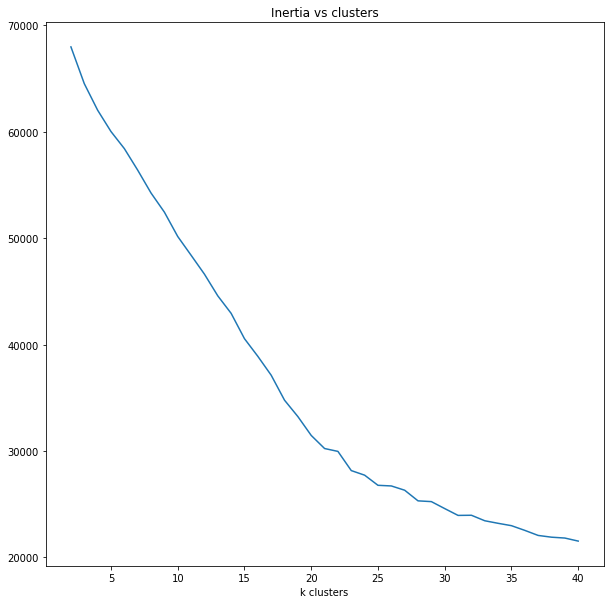

In [20]:
#Inertia
plt.figure(figsize=(10,10))
plt.plot(ks,inertias)
plt.xlabel('k clusters')
plt.title('Inertia vs clusters')
plt.show()

**Dendrograma modelo2**

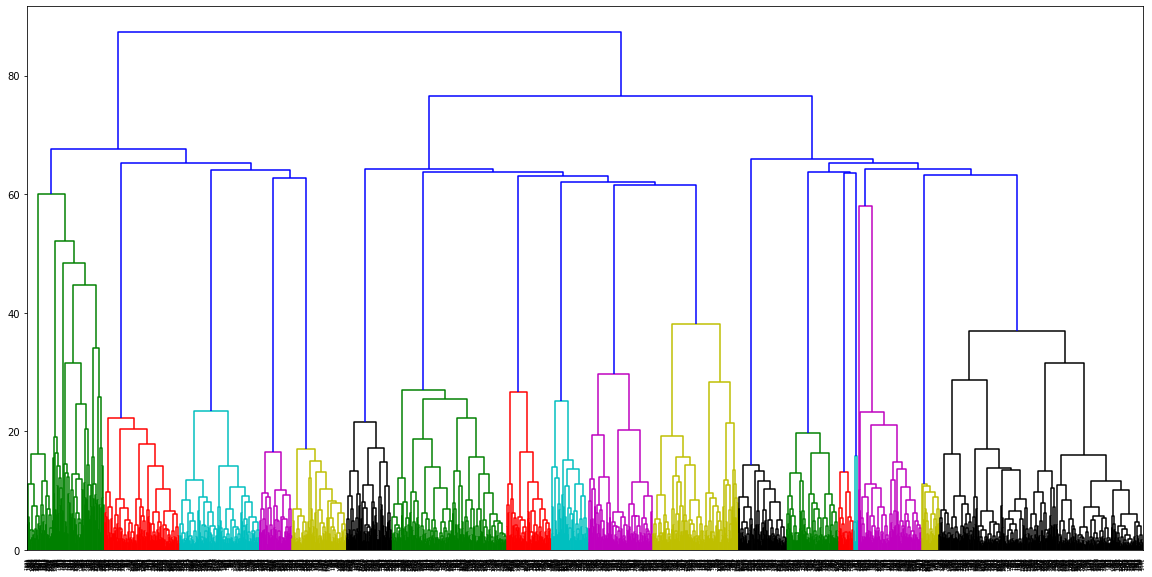

In [21]:
plt.figure(figsize=(20,10))
X=df2.values
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

**Agglomerative Clustering modelo2**

In [22]:
sil_Ac=[]
for i in ks:    
    model=AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X,labels)
    sil_Ac.append(silhouette_avg)

**Silhouette modelo2**

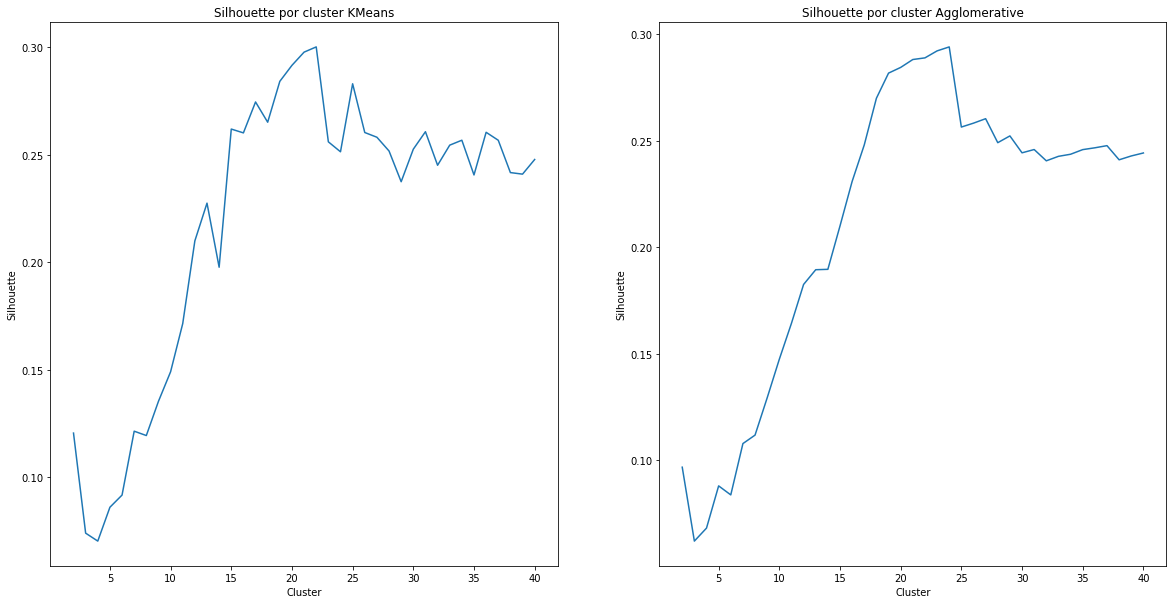

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(ks,sil_K)
plt.title('Silhouette por cluster KMeans')
plt.xlabel('Cluster')
plt.ylabel('Silhouette')

plt.subplot(1,2,2)
plt.plot(ks,sil_Ac)
plt.title('Silhouette por cluster Agglomerative')
plt.xlabel('Cluster')
plt.ylabel('Silhouette')
plt.show()

In [24]:
#Silhouette maximo,n clusters
print('Kmeans:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_K),ks[np.argmax(sil_K)] ))
print('\nAgglomerative:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_Ac),ks[np.argmax(sil_Ac)] ))

Kmeans:
silhouette: 0.300251, n clusters: 22

Agglomerative:
silhouette: 0.294017, n clusters: 24


In [26]:
model=KMeans(n_clusters=22)

In [27]:
labels = model.fit_predict(df2)

In [28]:
pd.crosstab(labels,df_s.UniqueCarrier)

UniqueCarrier,9E,AA,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV
row_0,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63
1,1,9,1,4,0,2,1,0,0,0,2,4,0,0,4,3,4,0,0
2,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,190,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,137,0,0,0,0,0
4,0,19,0,1,0,21,0,0,0,0,0,2,0,0,12,6,22,0,0
5,0,0,0,0,0,0,0,0,0,0,150,0,0,0,0,0,0,0,0
6,0,0,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,86,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,0,0,0,0


Vemos en la tabla cruzada que los clusters creados coinciden en gran parte con cada aerolínea, por lo que deducimos que esta feature es la principal variable por la que los algoritmos agrupan. La gráfica de inertia nos da un valor de 22 que coincide con el valor de la máxima silohuette que es 0.30.
En este caso KMeans y aglomerativo tienen un comportamiento similar.

**Tercer modelo**

Features numéricas

In [29]:
df_s.drop(['UniqueCarrier'],'columns',inplace=True)

In [30]:
#Estandarización
df_ts = StandardScaler().fit_transform(df_s)
df3=pd.DataFrame(df_ts,columns=df_s.columns, index=df_s.index)

**Kmeans modelo3**

In [31]:
#40 clusters
ks=range(2,41)
inertias=[]
sil_K=[]
for i in ks:
    model=KMeans(n_clusters=i, random_state=0)
    model.fit(df3)   
    inertias.append(model.inertia_)    
    labels = model.predict(df3)
    silhouette_avg = silhouette_score(df3,labels)
    sil_K.append(silhouette_avg) 

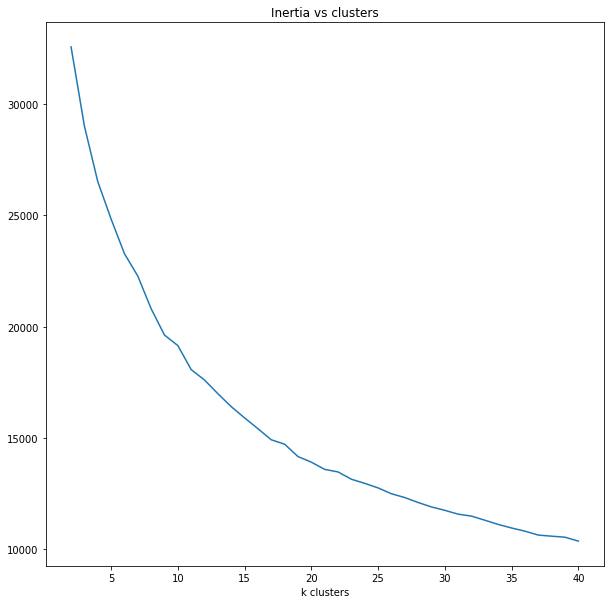

In [32]:
#Inertia
plt.figure(figsize=(10,10))
plt.plot(ks,inertias)
plt.xlabel('k clusters')
plt.title('Inertia vs clusters')
plt.show()

**Dendrograma modelo3**

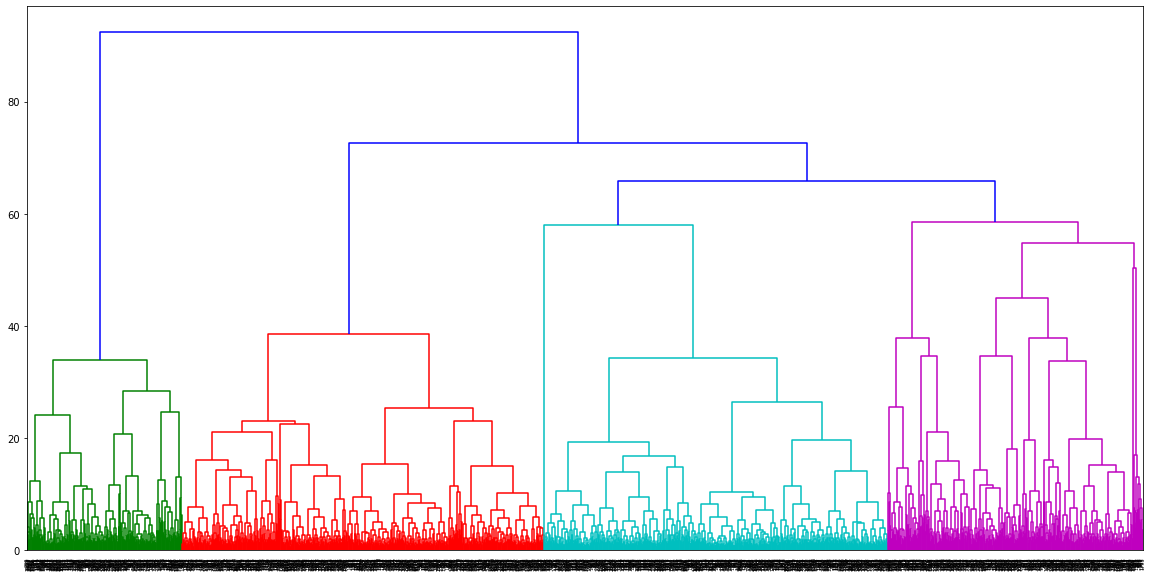

In [33]:
plt.figure(figsize=(20,10))
X=df3.values
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

**Agglomerative Clustering modelo3**

In [34]:
sil_Ac=[]
for i in ks:    
    model=AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X,labels)
    sil_Ac.append(silhouette_avg)

**Silhouette modelo3**

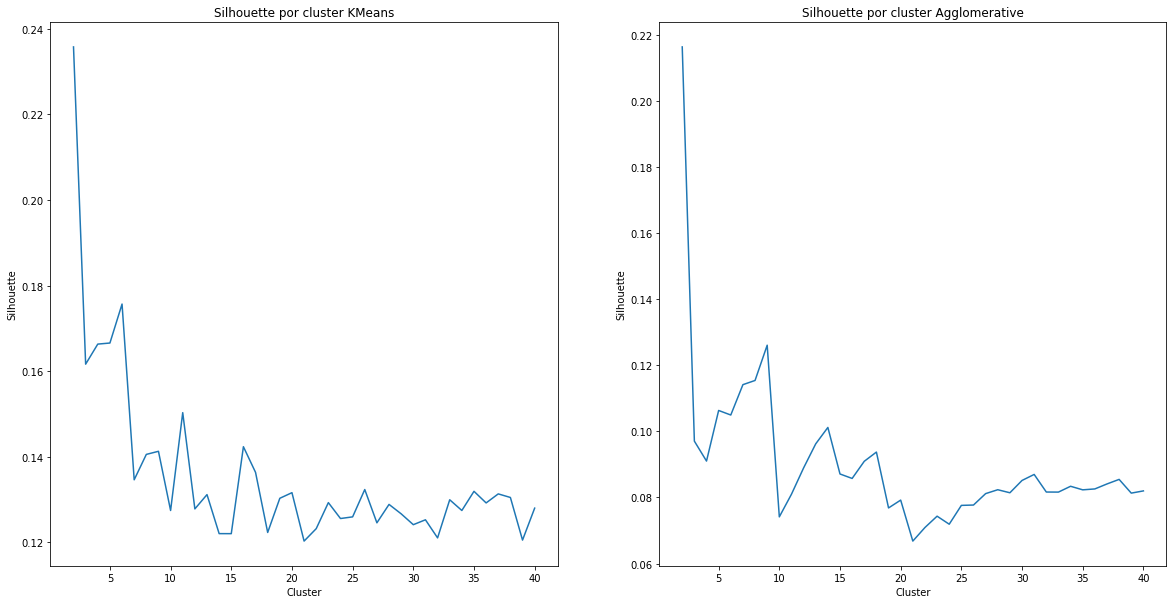

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(ks,sil_K)
plt.title('Silhouette por cluster KMeans')
plt.xlabel('Cluster')
plt.ylabel('Silhouette')

plt.subplot(1,2,2)
plt.plot(ks,sil_Ac)
plt.title('Silhouette por cluster Agglomerative')
plt.xlabel('Cluster')
plt.ylabel('Silhouette')
plt.show()

In [36]:
#Silhouette maximo,n clusters
print('Kmeans:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_K),ks[np.argmax(sil_K)] ))
print('\nAgglomerative:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_Ac),ks[np.argmax(sil_Ac)] ))

Kmeans:
silhouette: 0.235723, n clusters: 2

Agglomerative:
silhouette: 0.216497, n clusters: 2


Para inertia el primer cambio importante en la dirección de la curva que mejor se aprecia es para k=4. En cambio para silhouette, en los dos algoritmos, el máximo valor se produce en k=2. También en el dendrograma se muestra que la mayor distancia sin cambios en el número de clusters es para k=2.
Los dos algoritmos tienen un comportamiento similar aunque obtiene una mejor silhouette el KMeans.

En KMeans el que ofrece un mejor comportamiento es el modelo 2 usando k=22 clusters y una silhouette de 0.3, seguido del modelo 3 con k=2 y silhouette 0.23 y en último lugar el modelo 1 con un valor de silhouette muy malo.

In [ ]:
#Silhouette maximo,n clusters
print('Kmeans:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_K),ks[np.argmax(sil_K)] ))
print('\nAgglomerative:')
print('silhouette: %f, n clusters: %i'%(np.max(sil_Ac),ks[np.argmax(sil_Ac)] ))

In [ ]:
#plt.figure(figsize=(10,10))
plt.scatter(df2.iloc[:,8], df2.iloc[:,9], c=labels1)
centers = model.cluster_centers_
plt.scatter(centers[:, 8], centers[:, 9], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
        plt.scatter(c[8], c[9], marker='$%d$' % i, alpha=1,
                    s=80, edgecolor='r')
plt.xlabel('Air Time')
plt.ylabel('Arr Delay')
plt.title('Clusters flights')
plt.show()

# Nivell 2
#### Exercici 2
Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.

Hemos hecho el análisis aglomerativo en los tres modelos en el apartado anterior. Usando este algoritmo el que tiene mejor comportamiento es el modelo 1 con k=2 clusters y silhouette 0.4, seguido del modelo 2 con k=24 y silhouette 0.29 y por último el modelo 3 con k=2 clusters y silhouette 0.21.
El modelo 2 y 3 tienen un comportamiento similar en los dos algoritmos mientras que en el modelo 1 el aglomerativo se comporta mucho mejor.

# Nivell 3
#### Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

También hemos hecho el análisis de silhouette en el primer apartado para los tres modelos y los dos algoritmos.

Por último vamos a mostrar gráficamente las silhouettes que se generan por cada cluster y el valor medio de silhouette que es el que hemos usado anteriormente para buscar la mejor segmentación

Usamos el modelo 3 y clusters 2 y 3

#### Gráficos de silhouette para modelos con distintos clusteres

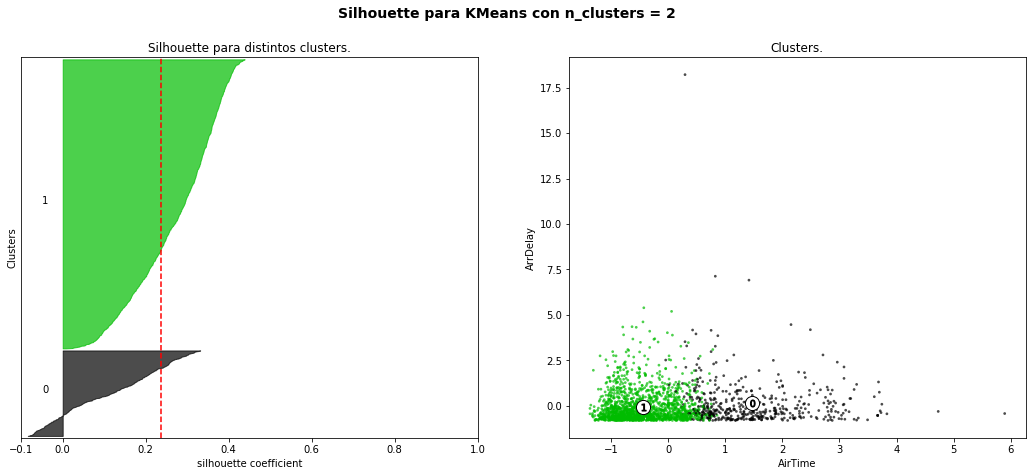

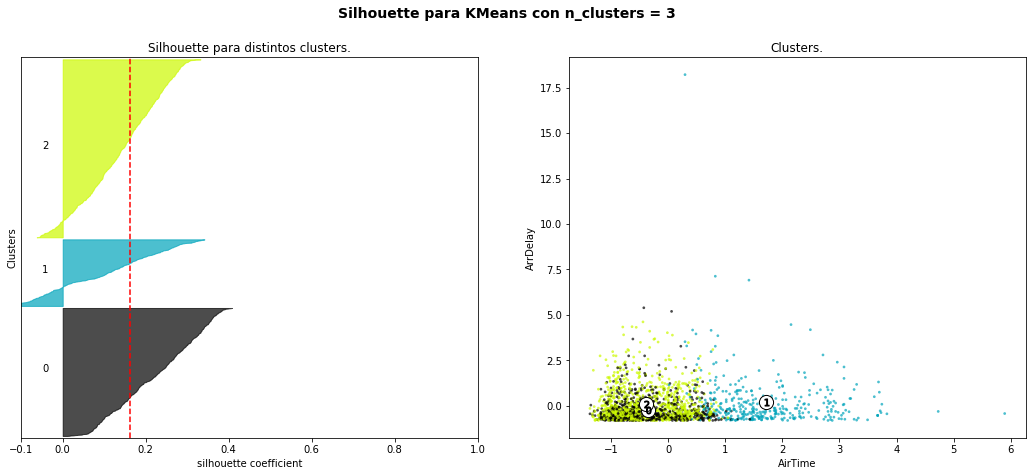

In [47]:
range_n_clusters=ks[:2]
x=df3
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    #print("For n_clusters =", n_clusters,
     #     "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette para distintos clusters.")
    ax1.set_xlabel("silhouette coefficient")
    ax1.set_ylabel("Clusters")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 8], X[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 8], centers[:, 9], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[8], c[9], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clusters.")
    ax2.set_xlabel("AirTime")
    ax2.set_ylabel("ArrDelay")

    plt.suptitle(("Silhouette para KMeans "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

A la izquierda vemos los valores de silhouette para cada cluster, la línea roja es la media de los silohuettes que hemos calculado anteriormente.